# Diffusion

## Forward Diffusion Process:

$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \qquad \epsilon \sim N(0, I)$$

Variance preserving

$$x_{t-1} \sim N(0, I) \implies \text{Var}[x_t] = (1 - \beta_t) + \beta_t = 1$$

Sampling $x_t$ in a single step:

$$\text{Let } \alpha_t = 1 - \beta_t, \qquad \bar \alpha_t = \prod_{t=1}^T \alpha_t$$

$$
\begin{align*}

x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \left[ \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}} \epsilon \right] + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{1 - \beta_t} \sqrt{\beta_{t-1}} \epsilon + \sqrt{\beta_t} \epsilon \\

&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \epsilon \\

x_t &= \sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon \\
\end{align*}
$$

## Reverse Diffusion Process:

Train a neural network that models:

$$p_\theta(x_{t-1} | x_t) = N(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right)$$

Loss:

$$
\begin{align*}

L &= \mathbb{E} \left[ \frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}
||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right] \\ \\

L_\text{simple} &= \mathbb{E} \left[ ||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right]

\end{align*}
$$

Sampling:

$$
\begin{align*}
& x_T \sim N(0, I) \\

& \text{for t in T..1}: \\
& \qquad \epsilon \sim N(0, I) \ \text{ if } t > 1 \ \text{ else } 0 \\
& \qquad x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t \epsilon

\end{align*}
$$

Alternate interpretation of diffusion from Langevin Dynamics: diffusion models learn $\nabla_x \log p(x)$, the way the image should be perturbed (denoised) to make it match the data distribution.

What does the reweighted objective $L_\text{simple}$ change? First we must schedule $\beta_t$

## $\beta_t$ schedule

Desmos plots: https://www.desmos.com/calculator/74swzuyya5

$$\alpha_t = \text{max}(\frac{\bar \alpha_t}{\bar \alpha_{t-1}}, 0.001) \qquad \beta_t = 1 - \alpha_t$$

$$\bar \alpha_t = \frac{f(t)}{f(0)} \qquad f(t) = \cos^2 \left( \frac{t / T + s}{1 + s} \cdot \frac{\pi}{2} \right)$$

This noise schedule strongly prioritizes the low noise regime, very gradually increasing noise for a long time, and only adding a lot of noise only for $t$ very close to the $T$. This schedule makes the model spend less time denoising extremely noisy images, which doesn't matter as much as denoising coherent images.

So back to the important question: What does the reweighted objective $L_\text{simple}$ change?

The scaling term dropped by the reweighted objective is

$$\frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}$$

This term is very very small until it blows up when $t$ gets close to $T$. By removing this weighting term, we are again decreasing the importance the model gives to denoising extremely noisy images and focusing the model on more meaningful denoising steps.

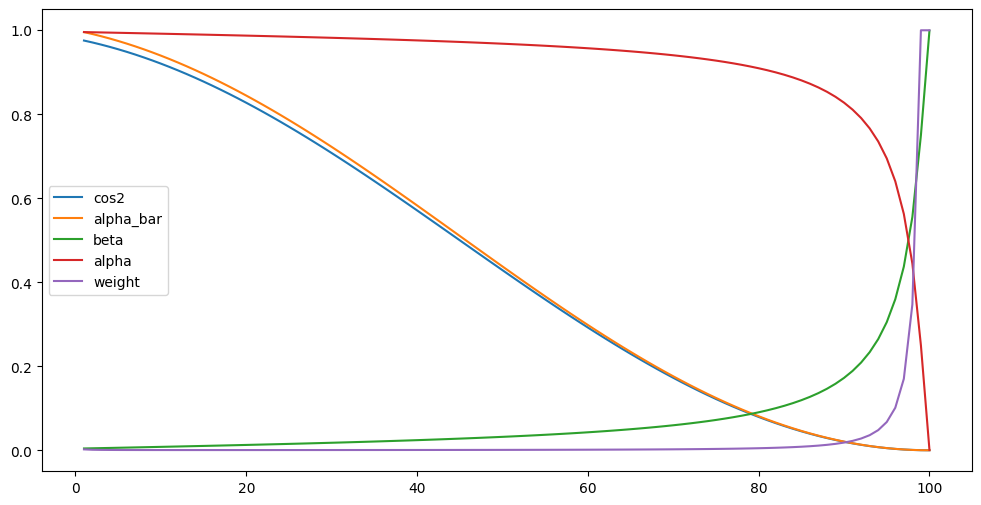

In [1]:
import torch
import matplotlib.pyplot as plt


def calc_cos_schedule(t: torch.Tensor, T: int, s: float = 0.1) -> torch.Tensor:
    phase = ((t / T) + s) / (1 + s)
    return torch.cos(phase * (torch.pi / 2.0)) ** 2.0

def calc_alpha_bar(t: torch.Tensor, T: int) -> torch.Tensor:
    return calc_cos_schedule(t, T) / calc_cos_schedule(torch.tensor(0.0), T)

def calc_alpha(t: torch.Tensor, T: int) -> torch.Tensor:
    a = calc_alpha_bar(t, T) / calc_alpha_bar(t - 1, T)
    return torch.maximum(a, torch.tensor(0.001))

def calc_beta(t: torch.Tensor, T: int) -> torch.Tensor:
    # a = alpha_bar(t, T) / alpha_bar(t - 1, T)
    # return torch.minimum(1 - a, torch.tensor(0.999))
    return 1 - calc_alpha(t, T)


T = 100
t = torch.arange(1, T + 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, calc_cos_schedule(t, T), label="cos2")

alpha_bar = calc_alpha_bar(t, T)
ax.plot(t, alpha_bar, label="alpha_bar")

ax.plot(t, calc_beta(t, T), label="beta")

alpha = calc_alpha(t, T)
ax.plot(t, alpha, label="alpha")

dropped_weight = ((1 - alpha) ** 2) / (2 * alpha * (1 - alpha_bar))
dropped_weight.clip_(max=1)
ax.plot(t, dropped_weight, label="weight")

ax.legend()
plt.show()

torch.Size([60000, 1, 28, 28])


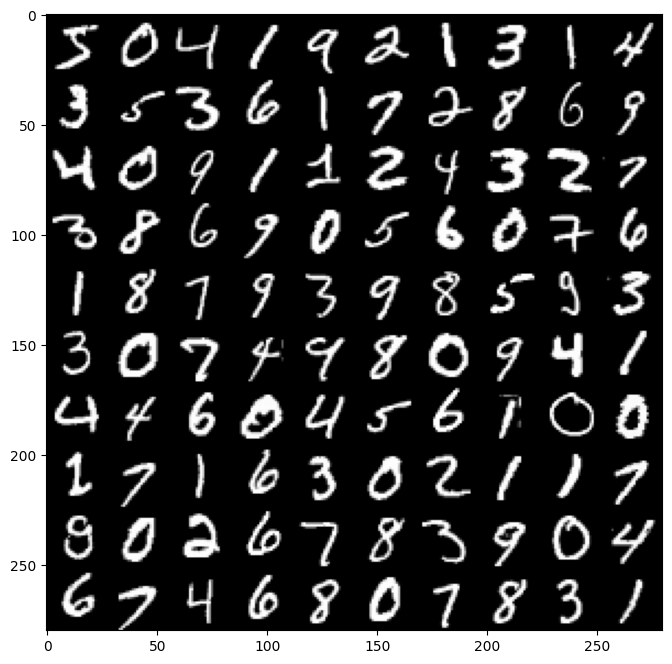

In [2]:
from torchvision.datasets import MNIST
from einops import rearrange


ds = MNIST(root="data", train=True, download=True)
images, labels = ds.data, ds.targets

images = images.to(dtype=torch.float32)
# images = (images - images.mean()) / images.std()
# print(images.mean(), images.std())
images = (images / (255 / 2)) - 1
images = images.unsqueeze(-3)
print(images.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rearrange(images[:100], "(n b) c h w -> (n h) (b c w)", n=10), cmap="grey");
plt.show()

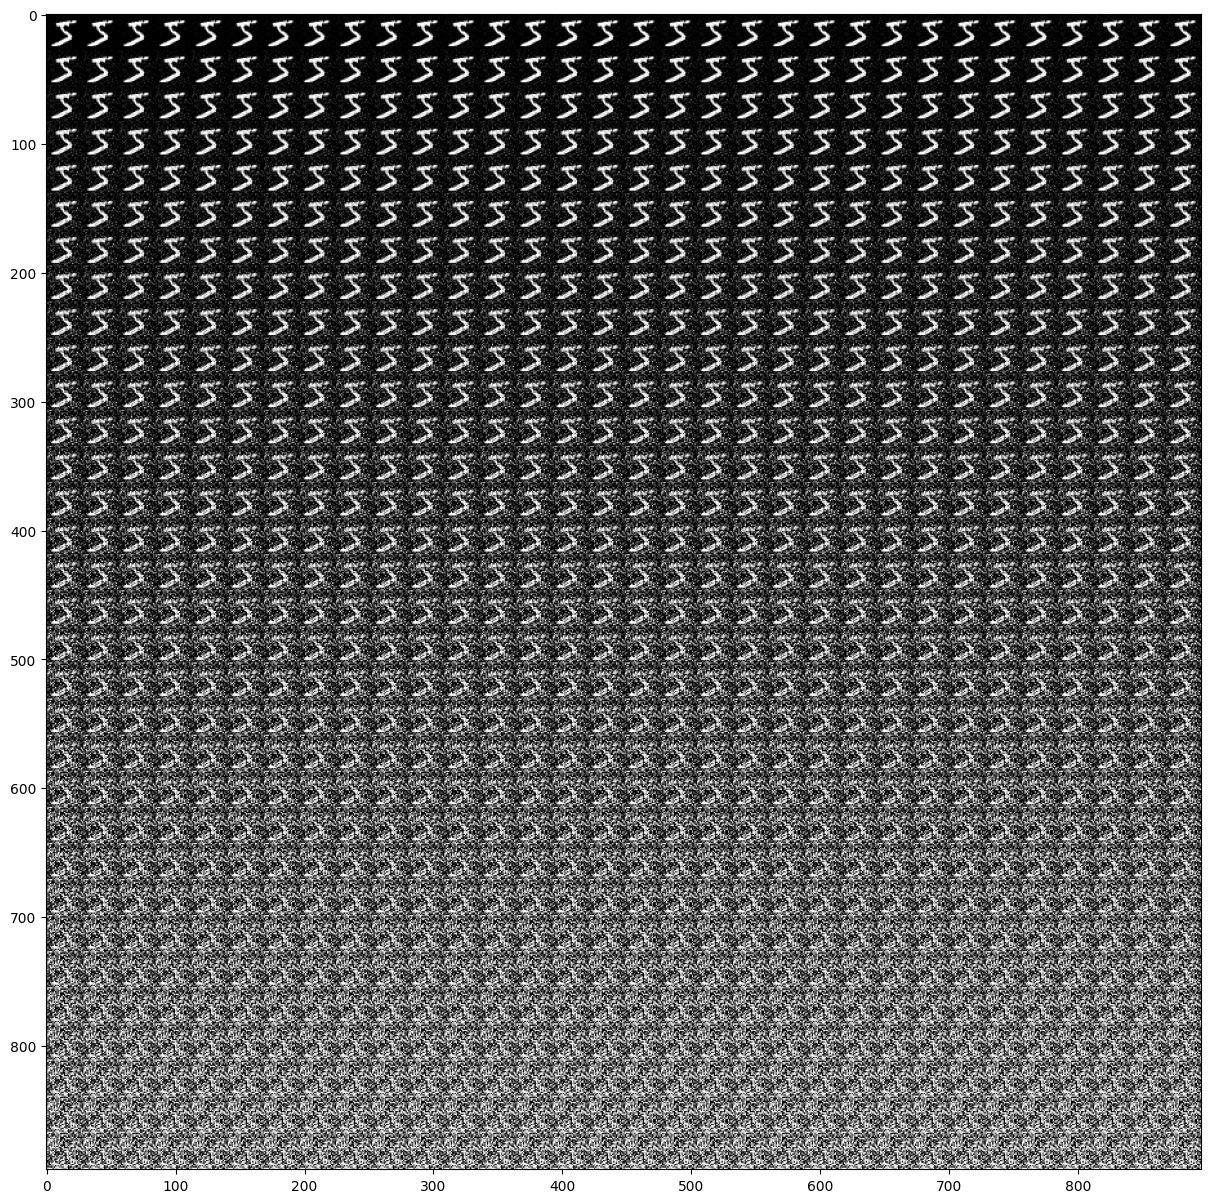

In [3]:
def add_noise(xs: torch.Tensor, t: torch.Tensor, T: int) -> tuple[torch.Tensor, torch.Tensor]:
    alpha_bars = calc_alpha_bar(t, T)
    alpha_bars = rearrange(alpha_bars, "b -> b 1 1 1")
    noise = (1 - alpha_bars).sqrt() * torch.randn_like(xs)
    return noise, (alpha_bars.sqrt() * xs) + noise


T = 1024
_, noised = add_noise(images[:1], torch.arange(T), T)
noised.clip_(-1, 1)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(rearrange(noised, "(n b) c h w -> (n h) (b c w)", n=32), cmap="grey");
plt.show()